In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from full_fred.fred import Fred

In [45]:
fred = Fred('../data/api_key')
fred.get_api_key_file()

'../data/api_key'

In [28]:
df = pd.read_csv('../data/national_summary.csv')

In [29]:
df.head()

,report
1970-01-01,NaN
1970-02-01,NaN
1970-03-01,NaN
1970-04-01,NaN
1970-05-20,This initial report of economic conditions in ...


In [30]:
df.isna().sum()

report    186
dtype: int64

In [31]:
len(df)

648

In [32]:
round((186/648)*100, 2)

28.7

A good 30% of the data is missing. I want to see how this changes over time:

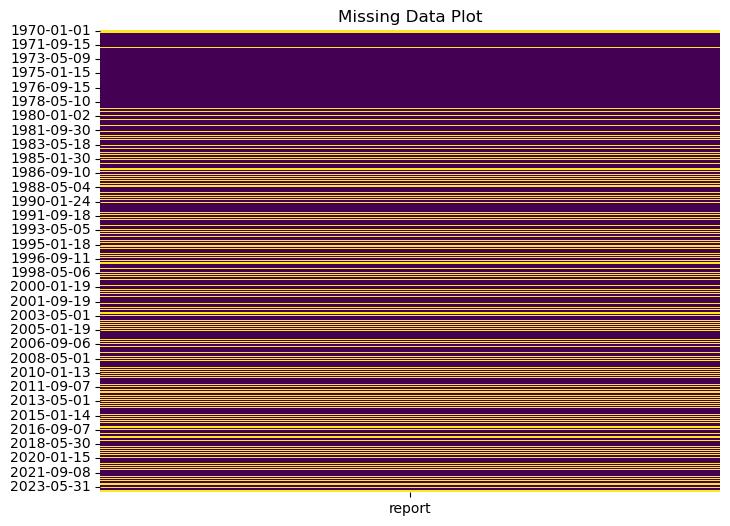

In [33]:
plt.figure(figsize = (8, 6))
sns.heatmap(df.isnull(), cbar = False, cmap = 'viridis')
plt.title('Missing Data Plot')
plt.show()

Not all of the months I attemped to access actually have Beige Book reports. I think this is partially due to some reports not being available, and partially because the Federal Reserve only releases eight Beige Book reports annually, so not every month and year combination I tried will be a valid URL. I will carry the last observation forward to impute the missing data, i.e. assume that the previous period's report is the most accurate representation of conditions for the missing reporting period.

In [34]:
df['report'].fillna(method = 'ffill', inplace=True)

In [35]:
df.isna().sum()

report    4
dtype: int64

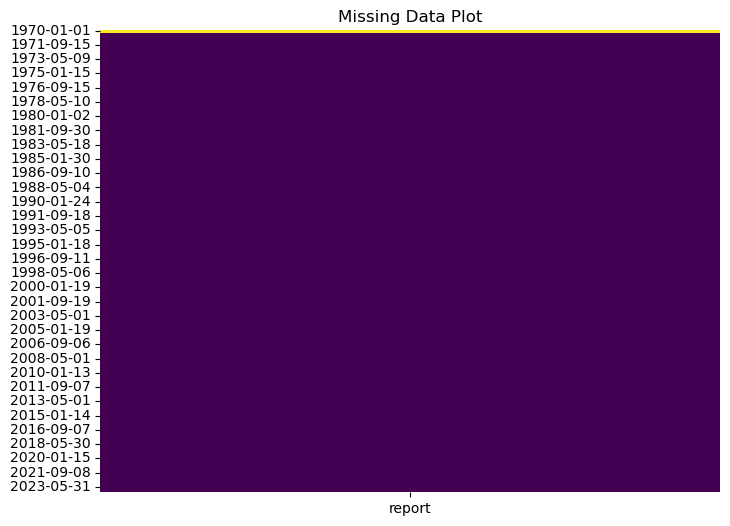

In [36]:
plt.figure(figsize = (8, 6))
sns.heatmap(df.isnull(), cbar = False, cmap = 'viridis')
plt.title('Missing Data Plot')
plt.show()

In [37]:
df.head()

,report
1970-01-01,NaN
1970-02-01,NaN
1970-03-01,NaN
1970-04-01,NaN
1970-05-20,This initial report of economic conditions in ...


---------

In [59]:
def get_fred():
    test =  fred.get_series_df('GDPPOT')[['date', 'value']]
    return test

In [60]:
get_fred()

,date,value
0,1949-01-01,.
1,1949-04-01,.
2,1949-07-01,.
3,1949-10-01,.
4,1950-01-01,2218.5665855133384
...,...,...
335,2032-10-01,.
336,2033-01-01,.
337,2033-04-01,.
338,2033-07-01,.


In [115]:
def get_fred():
    fred_df = pd.DataFrame()
    for metric in ['GDPPOT', 
                   'GDP', 
                   'FPCPITOTLZGUSA', 
                   'CORESTICKM159SFRBATL', 
                   'UNRATE',
                   'gnpca',
                   'PRS85006092', 
                   'MPU4900083']:
    
        metric_output =  fred.get_series_df(metric)[['date', 'value']]
        metric_output.set_index('date', inplace = True)
        
        metric_output['value'] = [float(v) if v != '.' else np.nan for v in metric_output['value']]
        
        metric_output.index = pd.to_datetime(metric_output.index)
        metric_output = metric_output.rename(columns = {'value': f"{metric}"})
        fred_df = metric_output.join(fred_df, how = 'outer')
    return fred_df

In [116]:
fred_df = get_fred()
fred_df.head()

C:\Users\User\AppData\Local\Temp\ipykernel_6760\2387484144.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric_output['value'] = [float(v) if v != '.' else np.nan for v in metric_output['value']]
C:\Users\User\AppData\Local\Temp\ipykernel_6760\2387484144.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric_output['value'] = [float(v) if v != '.' else np.nan for v in metric_output['value']]
C:\Users\User\AppData\Local\Temp\ipykernel_6760\2387484144.py:15: SettingWithCopyWarning: 
A value is tr

,MPU4900083,PRS85006092,gnpca,UNRATE,CORESTICKM159SFRBATL,FPCPITOTLZGUSA,GDP,GDPPOT
date,,,,,,,,
1929-01-01,NaN,NaN,1120.718,NaN,NaN,NaN,NaN,NaN
1930-01-01,NaN,NaN,1025.678,NaN,NaN,NaN,NaN,NaN
1931-01-01,NaN,NaN,958.927,NaN,NaN,NaN,NaN,NaN
1932-01-01,NaN,NaN,834.769,NaN,NaN,NaN,NaN,NaN
1933-01-01,NaN,NaN,823.628,NaN,NaN,NaN,NaN,NaN


In [120]:
fred_df.loc['2022-10-01']

MPU4900083                       NaN
PRS85006092                 1.600000
gnpca                            NaN
UNRATE                      3.700000
CORESTICKM159SFRBATL        6.364809
FPCPITOTLZGUSA                   NaN
GDP                     26137.992000
GDPPOT                  20334.210000
Name: 2022-10-01 00:00:00, dtype: float64

In [114]:
fred_df[fred_df['GDP'] < 26137.992]['GDP']

date
1988-01-01     5073.372
1989-01-01     5511.253
1990-01-01     5872.701
1991-01-01     6035.178
1992-01-01     6363.102
1993-01-01     6729.459
1994-01-01     7115.652
1995-01-01     7522.289
1996-01-01     7868.468
1997-01-01     8362.655
1998-01-01     8866.480
1999-01-01     9411.682
2000-01-01    10002.179
2001-01-01    10470.231
2002-01-01    10783.500
2003-01-01    11174.129
2004-01-01    11923.447
2005-01-01    12767.286
2006-01-01    13599.160
2007-01-01    14215.651
2008-01-01    14706.538
2009-01-01    14430.901
2010-01-01    14764.611
2011-01-01    15351.444
2012-01-01    16068.824
2013-01-01    16629.050
2014-01-01    17144.281
2015-01-01    17991.348
2016-01-01    18425.306
2017-01-01    19148.194
2018-01-01    20155.486
2019-01-01    21013.085
2020-01-01    21538.032
2021-01-01    22313.850
2022-01-01    24740.480
Name: GDP, dtype: float64

In [111]:
fred_df.dtypes

MPU4900083              float64
PRS85006092             float64
gnpca                   float64
UNRATE                  float64
CORESTICKM159SFRBATL    float64
FPCPITOTLZGUSA          float64
GDP                     float64
GDPPOT                  float64
dtype: object

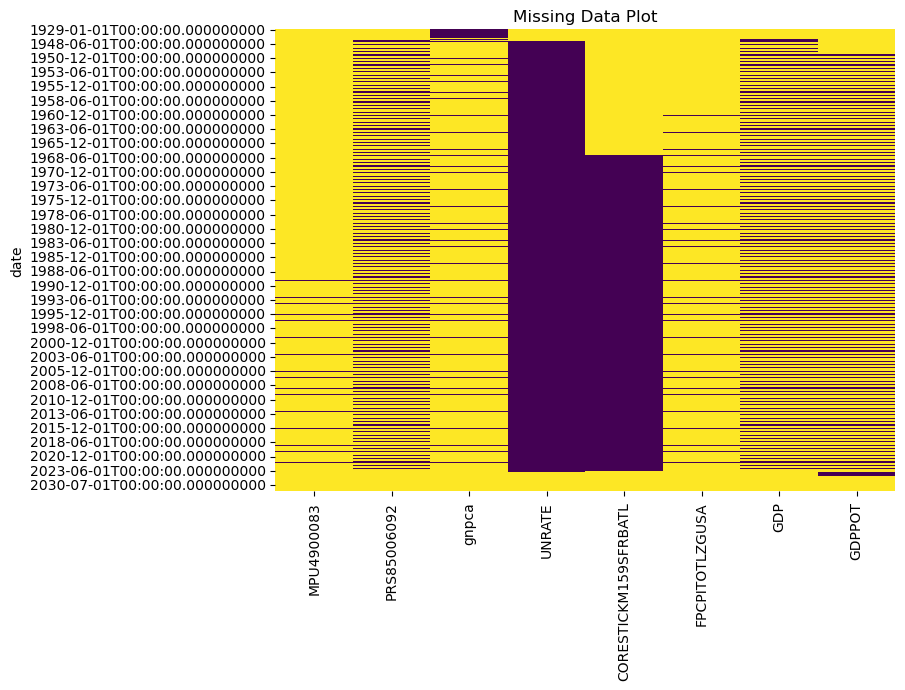

In [123]:
plt.figure(figsize = (8, 6))
sns.heatmap(fred_df.isnull(), cbar = False, cmap = 'viridis')
plt.title('Missing Data Plot')
plt.show()

-------


In [124]:
def get_fred2():
    fred_df = pd.DataFrame()
    for metric in ['GDPPOT', 
                   'GDP', 
                   'FPCPITOTLZGUSA', 
                   'CORESTICKM159SFRBATL', 
                   'UNRATE',
                   'gnpca',
                   'PRS85006092', 
                   'MPU4900083']:
    
        metric_output =  fred.get_series_df(metric)[['date', 'value']]
        metric_output.set_index('date', inplace = True)
        
        metric_output['value'] = [float(v) if v != '.' else np.nan for v in metric_output['value']]
        
        metric_output.index = pd.to_datetime(metric_output.index)
        metric_output = metric_output.rename(columns = {'value': f"{metric}"})
        fred_df = metric_output.join(fred_df)
    return fred_df

In [125]:
fred_df_inner = get_fred2()

C:\Users\User\AppData\Local\Temp\ipykernel_6760\4032784566.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric_output['value'] = [float(v) if v != '.' else np.nan for v in metric_output['value']]
C:\Users\User\AppData\Local\Temp\ipykernel_6760\4032784566.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metric_output['value'] = [float(v) if v != '.' else np.nan for v in metric_output['value']]
C:\Users\User\AppData\Local\Temp\ipykernel_6760\4032784566.py:15: SettingWithCopyWarning: 
A value is tr

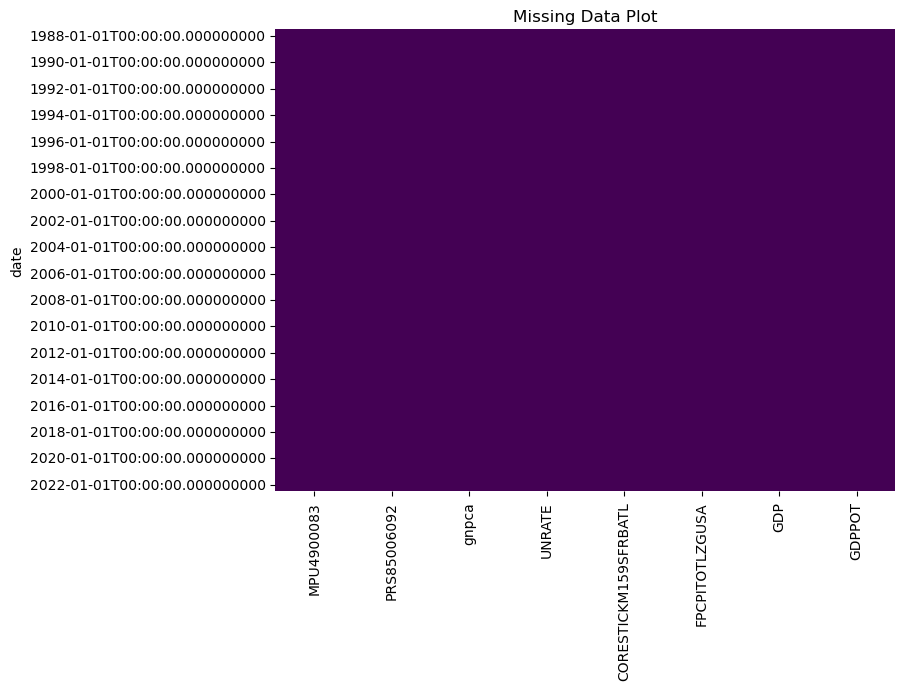

In [126]:
plt.figure(figsize = (8, 6))
sns.heatmap(fred_df_inner.isnull(), cbar = False, cmap = 'viridis')
plt.title('Missing Data Plot')
plt.show()